# Conversion rate

by Ben Lacar
3/3/20

## Problem statement and goal

You are working for an e-commerce company. The company wants to optimize the conversion rate for its website. Conversion refers to the action the company wants the user to take, which in this case is making a purchase. The conversion rate is simply the number of conversions divided by the total number of visitors the page receives.

*Optimizing conversion rates is a very common task for a data scientist, and rightfully so. We are able to collect all sorts of data about people who buy something on our website as well as about people who don't. This gives us a tremendous opportunity to understand what's working well (and potentially scale it even further) and what's not working well (and fix it).*

*In brief, the goal of this exercise is to explore the available data, build a model that predicts conversion rate and, based on the model, come up with ideas to improve revenue.
The problem is very straightforward, there are no dates, no tables to join, no feature engineering required. This exercise is a great starting point to get familiar with the general structure of data challenges, which are a common part of interviews for Data Scientist roles.*

## Exercise description

We have data about users who hit our site. We know whether they converted or not, as well as some of their basic characteristics such as the country they’re in, the marketing channel that brought them to the site, their age, whether they are repeat users, and the number of pages visited during that session (as a proxy for site activity/time spent on the site).


Your project is to:
1. Perform Exploratory Data Analysis and produce 2-3 plots that show either important features or interesting patterns in the data. It is up to you what you want to highlight.
2. Perform cohort analysis based on the source of the customer.
3. Come up with recommendations for the product team and the marketing team to improve conversion rate.

## Description of features

The table is called "conversion_data". It has information about signed-in users during one session.
Each row is an individual user session.

- country: user country based on the IP address
- age: user age. Self-reported at sign-in step.
- new_user: whether the user created the account during this session or had already an account and simply came back to the site
- source: marketing channel source
    - Ads: came to the site by clicking on an advertisement
    - Seo: came to the site by clicking on search results
    - Direct: came to the site by directly typing the URL on the browser
- total_pages_visited: number of total pages visited during the session. This is a proxy for time spent on site and engagement during the session.
- converted: this is our label. 1 means they converted within the session, 0 means they left without buying anything. The company goal is to increase conversion rate: # conversions / total sessions.

# Table of Contents
- Initial Data Analysis
- Data Wrangling
- Exploratory Data Analysis
- Cohort analysis
- Questions/Answers + Methodology
- Conclusions

In [1]:
# Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
import pandas_profiling as pp
import etsy_py
from scipy.stats import shapiro
from scipy.stats import skew
from scipy.stats import kurtosis

In [2]:
# Stats
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [3]:
# Code formatting Jupyter black
%load_ext nb_black

<IPython.core.display.Javascript object>

In [4]:
# Termcolor
from termcolor import colored

<IPython.core.display.Javascript object>

# Initial Data Analysis

In [18]:
def initial_analysis(df):
    """
    Given a dataframe produces a simple report on initial data analytics
    Params:
        - df 
    Returns:
        - Shape of dataframe records and columns
        - Columns and data types
    """
    print("Report of Initial Data Analysis:\n")
    print(f"Shape of dataframe: {df.shape}")
    print(f"Features and Data Types: \n {df.dtypes}")

<IPython.core.display.Javascript object>

In [19]:
def percent_missing(df):
    """
    Given a dataframe it calculates the percentage of missing records per column
    Params:
        - df
    Returns:
        - Dictionary of column name and percentage of missing records
    """
    col = list(df.columns)
    perc = [round(df[c].isna().mean() * 100, 2) for c in col]
    miss_dict = dict(zip(col, perc))
    return miss_dict

<IPython.core.display.Javascript object>

In [20]:
def normality_test(df, col_list):
    """
    Given a dataframe determines whether each numerical column is Gaussian 
    Ho = Assumes distribution is not Gaussian
    Ha = Assumes distribution is Gaussian
    Params:
        - df
    Returns:
        - W Statistic
        - p-value
        - List of columns that do not have gaussian distribution
    """
    non_gauss = []
    w_stat = []
    # Determine if each sample of numerical feature is gaussian
    alpha = 0.05
    for n in numeric_list:
        stat, p = shapiro(df[n])
        print(sns.distplot(df[n]))
        print(tuple(skew(df[n]), kurtosis(df[n])))

        if p <= alpha:  # Reject Ho -- Distribution is not normal
            non_gauss.append(n)
            w_stat.append(stat)
    # Dictionary of numerical features not gaussian and W-Statistic
    norm_dict = dict(zip(non_gauss, w_stat))
    return norm_dict

<IPython.core.display.Javascript object>

In [21]:
os.listdir()

['Conversion Rate.pdf',
 '.DS_Store',
 'Lacar_Ben_dc3_product_analytics.ipynb',
 'conversion_data.csv',
 '.ipynb_checkpoints']

<IPython.core.display.Javascript object>

In [22]:
# Load data
df_conv = pd.read_csv("conversion_data.csv")  # , delimiter=",", index_col=0)
df_conv.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


<IPython.core.display.Javascript object>

In [10]:
initial_analysis(df_conv)

Report of Initial Data Analysis:

Shape of dataframe: (316200, 6)
Features and Data Types: 
 country                object
age                     int64
new_user                int64
source                 object
total_pages_visited     int64
converted               int64
dtype: object


<IPython.core.display.Javascript object>

In [11]:
percent_missing(df_conv)

{'country': 0.0,
 'age': 0.0,
 'new_user': 0.0,
 'source': 0.0,
 'total_pages_visited': 0.0,
 'converted': 0.0}

<IPython.core.display.Javascript object>

# Data Wrangling

## Check for duplicates

In [12]:
df_conv.duplicated()

0         False
1         False
2         False
3         False
4         False
          ...  
316195     True
316196     True
316197     True
316198     True
316199     True
Length: 316200, dtype: bool

<IPython.core.display.Javascript object>

In [15]:
df_conv.duplicated().sum()

299903

<IPython.core.display.Javascript object>

In [13]:
# Duplicates are not always next to each other
df_conv.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


<IPython.core.display.Javascript object>

In [16]:
df_conv.tail()

,country,age,new_user,source,total_pages_visited,converted
316195,US,26,1,Ads,9,0
316196,US,27,1,Direct,6,0
316197,China,25,0,Ads,4,0
316198,US,22,0,Seo,4,0
316199,UK,24,0,Ads,4,0


<IPython.core.display.Javascript object>

In [23]:
# duplicate rows
number_duplicate_rows = df_conv.duplicated().value_counts().loc[True]
percent_duplicate_rows = number_duplicate_rows / len(df_conv.index) * 100

text = colored(
    "%d rows (%.2f %%) are duplicates"
    % (number_duplicate_rows, percent_duplicate_rows),
    "red",
    attrs=["reverse"],
)
print(text)

299903 rows (94.85 %) are duplicates


<IPython.core.display.Javascript object>

In [29]:
# Sort values to see duplicates
df_conv.sort_values(
    by=["country", "age", "new_user", "source", "total_pages_visited", "converted"]
).head(20)

,country,age,new_user,source,total_pages_visited,converted
20029,China,17,0,Ads,1,0
21506,China,17,0,Ads,1,0
24947,China,17,0,Ads,1,0
112472,China,17,0,Ads,1,0
147042,China,17,0,Ads,1,0
157822,China,17,0,Ads,1,0
180647,China,17,0,Ads,1,0
221574,China,17,0,Ads,1,0
226909,China,17,0,Ads,1,0
233144,China,17,0,Ads,1,0


<IPython.core.display.Javascript object>

<font color='red'>I recognize that there are duplicates but given that the problem statement and the limited set of features given, I will assume that this is not really duplicated data. I believe that they are actually different unique users who share the same features. For example, above, it is plausible that there are 15 different users from China who are 17 years old and share the feature characteristics shown above. </font>

## Impute or deal with missing values

In [30]:
df_conv.isna().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

<IPython.core.display.Javascript object>

**The data shows no missing values.**

## Deal with non-numeric values

In [32]:
# Inspect unique values and their counts
for col in df_conv.columns:
    print(col, df_conv[col].value_counts())

country US         178092
China       76602
UK          48450
Germany     13056
Name: country, dtype: int64
age 30     14346
28     14341
29     14158
27     14084
26     13931
31     13692
32     13507
25     13460
24     12960
33     12631
23     12336
34     12108
22     11701
35     11471
21     10966
36     10779
20     10156
37      9761
19      9349
38      8970
18      8466
39      8202
17      7597
40      7148
41      6401
42      5588
43      4904
44      4224
45      3634
46      2994
47      2504
48      2121
49      1629
50      1356
51      1093
52       935
53       627
54       520
55       394
56       286
57       247
58       165
59       127
60        94
61        71
62        59
63        35
64        27
65        15
66         9
67         5
68         5
69         3
70         2
77         1
79         1
111        1
73         1
72         1
123        1
Name: age, dtype: int64
new_user 1    216744
0     99456
Name: new_user, dtype: int64
source Seo       15504

<IPython.core.display.Javascript object>

**Inspection of values shows no anamolous values in the features. We can also start to see more details of the features which we can later visualize. For example:**

-  4 unique countries with number of users from each in this order: US (178092), China (76602), UK (48450), Germany     (1305).
- Most users are in their late 20s, early 30s,
- Most are new users.
- About twice as many visited by clicking on search results compared to ads + direct search combined.
- Most visited two pages.
- The number who converted is a very small percentage of users (10,200 out of 316,200).

# Exploratory Data Analysis


In [249]:
# Set seaborn sizes
sns.set_context(
    "talk", rc={"font.size": 14, "axes.titlesize": 14, "axes.labelsize": 14}
)

<IPython.core.display.Javascript object>

In [257]:
def create_counts_converted_table_by_feature(df, feature):

    # age is arbitrarily chosen
    df_conv_feature_counts = df.groupby([feature, "converted"]).count()["age"].copy()
    return df_conv_feature_counts

<IPython.core.display.Javascript object>

In [251]:
def create_bar_plots(df_conv_feature_counts, feature, feature_order, xaxis_label_rot):

    non_converted_by_feature = [
        df_conv_feature_counts[feature, 0] for feature in feature_order
    ]
    converted_by_feature = [
        df_conv_feature_counts[feature, 1] for feature in feature_order
    ]

    conv_rate_by_feature = [
        100
        * (df_conv_feature_counts[feature, 1] / df_conv_feature_counts[feature].sum())
        for feature in feature_order
    ]

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    ind = np.arange(len(feature_order))

    ax1.bar(ind, non_converted_by_feature, color="gray", label="no conversion")
    ax1.bar(
        ind,
        converted_by_feature,
        bottom=non_converted_by_feature,
        color="green",
        label="conversion",
    )
    ax1.set_xticks(ind)
    labels = [item.get_text() for item in ax1.get_xticklabels()]
    ax1.set_xticklabels(feature_order, rotation=xaxis_label_rot)
    ax1.set_ylabel("number of users")
    ax1.legend()
    ax1.set_title("No. of users by " + feature)

    ax2.bar(
        ind, conv_rate_by_feature, color="green",
    )
    ax2.set_xticks(ind)
    labels = [item.get_text() for item in ax2.get_xticklabels()]
    ax2.set_xticklabels(feature_order, rotation=xaxis_label_rot)
    ax2.set_ylabel("percent of users")
    ax2.set_title("Pct. of converted users " + feature)

    plt.tight_layout()

<IPython.core.display.Javascript object>

In [37]:
df_conv.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


<IPython.core.display.Javascript object>

## Conversion by country

In [230]:
df_conv_country_counts = create_counts_converted_table_by_feature(df_conv, "country")
df_conv_country_counts

country  converted
China    0             76500
         1               102
Germany  0             12240
         1               816
UK       0             45900
         1              2550
US       0            171360
         1              6732
Name: age, dtype: int64

<IPython.core.display.Javascript object>

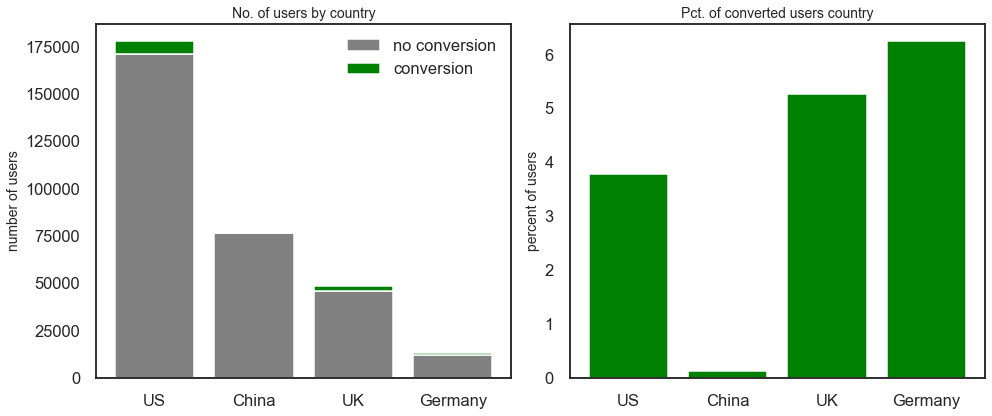

<IPython.core.display.Javascript object>

In [252]:
# Put the countries in descending order of total counts
country_order = (
    df_conv.groupby(["country"])
    .count()["age"]
    .copy()
    .sort_values(ascending=False)
    .index.tolist()
)
country_order
create_bar_plots(df_conv_country_counts, "country", country_order, 0)

## Conversion by age

Text(0.5, 1.0, 'Age distribution')

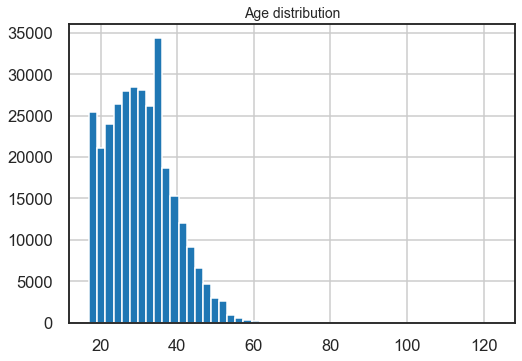

<IPython.core.display.Javascript object>

In [294]:
f, ax1 = plt.subplots()
df_conv["age"].hist(ax=ax1, bins=50, rwidth=1)
ax1.set_title("Age distribution")

In [296]:
df_conv["age"].mean()

df_conv["age"].median()

30.0

<IPython.core.display.Javascript object>

In [234]:
print("Min age: ", df_conv["age"].min(), "Max age: ", df_conv["age"].max())

Min age:  17 Max age:  123


<IPython.core.display.Javascript object>

In [235]:
# Bin age groups with quantile cuts
df_conv["age_groups"] = pd.qcut(df_conv["age"], 5)
df_conv["age_groups"].value_counts()

(16.999, 23.0]    70571
(23.0, 28.0]      68776
(32.0, 38.0]      65720
(28.0, 32.0]      55703
(38.0, 123.0]     55430
Name: age_groups, dtype: int64

<IPython.core.display.Javascript object>

**Note that pd.qcut does not exactly give equal numbers since duplicate values are splitting the places where a bin would be.**

In [236]:
df_conv_age_groups_counts = create_counts_converted_table_by_feature(
    df_conv, "age_groups"
)
df_conv_age_groups_counts

age_groups      converted
(16.999, 23.0]  0            66533
                1             4038
(23.0, 28.0]    0            66172
                1             2604
(28.0, 32.0]    0            54100
                1             1603
(32.0, 38.0]    0            64425
                1             1295
(38.0, 123.0]   0            54770
                1              660
Name: age, dtype: int64

<IPython.core.display.Javascript object>

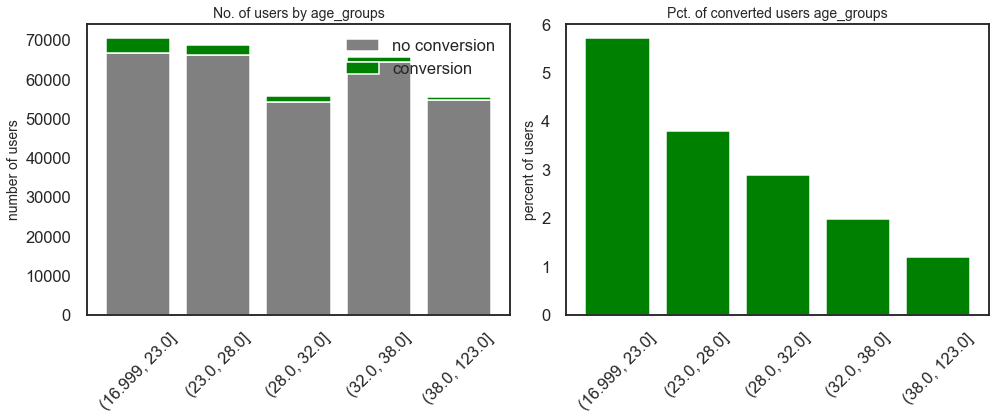

<IPython.core.display.Javascript object>

In [237]:
# Manually set age_groups order
age_groups_order = [
    i for i in df_conv_age_groups_counts.index.get_level_values(0).unique().tolist()
]
# age_groups_order = ["youngest", "young", "mid", "old", "older"]

create_bar_plots(df_conv_age_groups_counts, "age_groups", age_groups_order, 45)

## Conversion by new user

In [238]:
df_conv_new_user_counts = create_counts_converted_table_by_feature(df_conv, "new_user")
df_conv_new_user_counts

new_user  converted
0         0             92295
          1              7161
1         0            213705
          1              3039
Name: age, dtype: int64

<IPython.core.display.Javascript object>

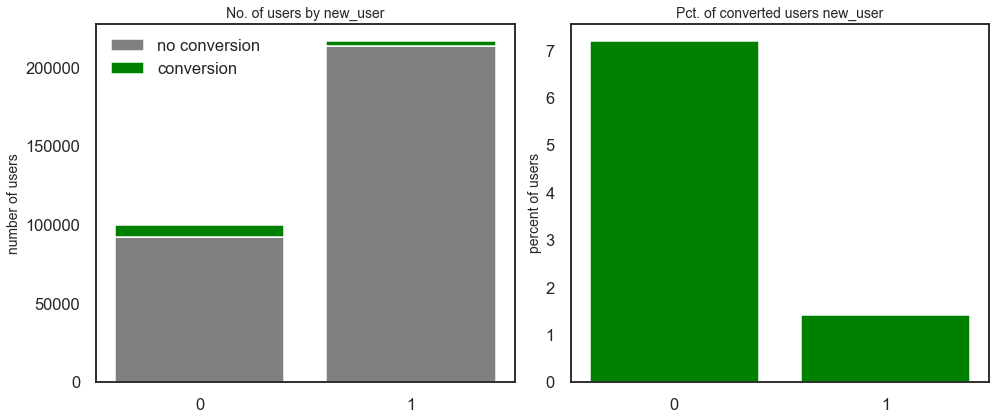

<IPython.core.display.Javascript object>

In [239]:
# Manually set new_user order
new_user_order = [0, 1]
create_bar_plots(df_conv_new_user_counts, "new_user", new_user_order, 0)

## Conversion by source

In [240]:
df_conv_source_counts = create_counts_converted_table_by_feature(df_conv, "source")
df_conv_source_counts

source  converted
Ads     0             85680
        1              3060
Direct  0             70380
        1              2040
Seo     0            149940
        1              5100
Name: age, dtype: int64

<IPython.core.display.Javascript object>

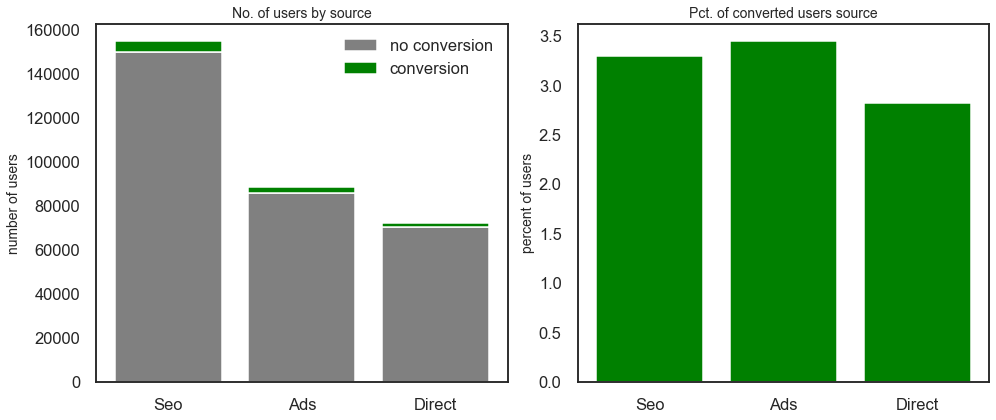

<IPython.core.display.Javascript object>

In [241]:
# Put the sources in descending order of total counts (age was arbitrarily chosen)
source_order = (
    df_conv.groupby(["source"])
    .count()["age"]
    .copy()
    .sort_values(ascending=False)
    .index.tolist()
)
# print(source_order)
create_bar_plots(df_conv_source_counts, "source", source_order, 0)

## Conversion by number of pages visited

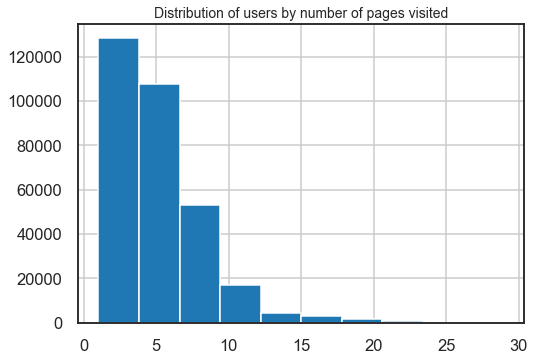

<IPython.core.display.Javascript object>

In [243]:
f, ax1 = plt.subplots()
df_conv["total_pages_visited"].hist(ax=ax1)
ax1.set_title("Distribution of users by number of pages visited")

In [198]:
# Bin number of page visits with quantile cuts
df_conv["total_page_visit_groups"] = pd.qcut(df_conv["total_pages_visited"], 5)
df_conv["total_page_visit_groups"].value_counts()

(0.999, 2.0]    84607
(3.0, 5.0]      77354
(7.0, 29.0]     56661
(5.0, 7.0]      53749
(2.0, 3.0]      43829
Name: total_page_visit_groups, dtype: int64

<IPython.core.display.Javascript object>

In [244]:
df_conv_total_page_visit_groups_counts = create_counts_converted_table_by_feature(
    df_conv, "total_page_visit_groups"
)
df_conv_total_page_visit_groups_counts

total_page_visit_groups  converted
(0.999, 2.0]             0            84597
                         1               10
(2.0, 3.0]               0            43818
                         1               11
(3.0, 5.0]               0            77265
                         1               89
(5.0, 7.0]               0            53486
                         1              263
(7.0, 29.0]              0            46834
                         1             9827
Name: age, dtype: int64

<IPython.core.display.Javascript object>

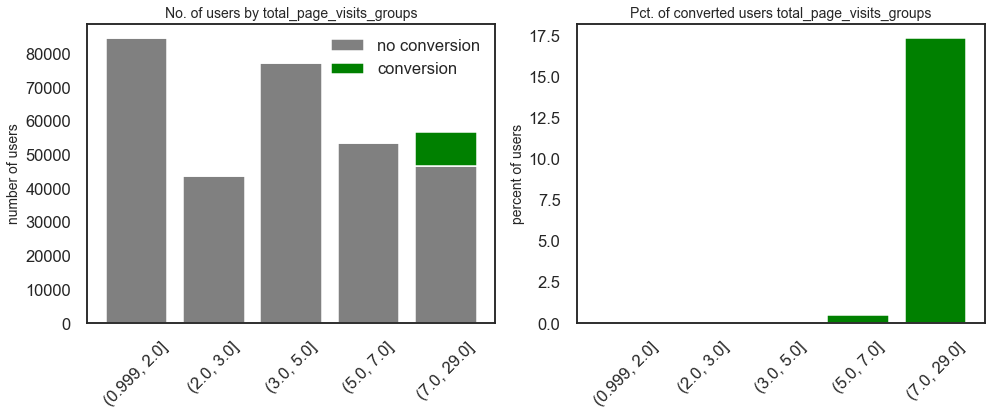

<IPython.core.display.Javascript object>

In [256]:
# Manually set total_page_visits_groups order
total_page_visits_groups_order = [
    i
    for i in df_conv_total_page_visit_groups_counts.index.get_level_values(0)
    .unique()
    .tolist()
]
total_page_visits_groups_order
create_bar_plots(
    df_conv_total_page_visit_groups_counts,
    "total_page_visits_groups",
    total_page_visits_groups_order,
    45,
)

Text(0.5, 1.0, 'Distribution of users by number of pages visited')

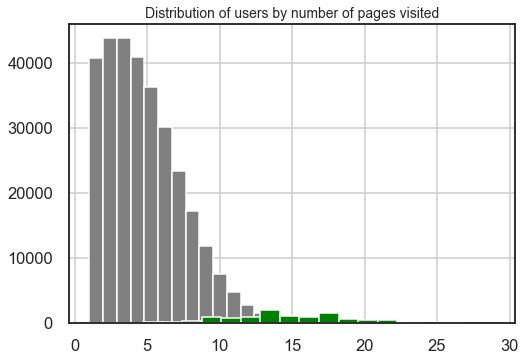

<IPython.core.display.Javascript object>

In [456]:
f, ax1 = plt.subplots()

df_conv_0 = df_conv[df_conv["converted"] == 0].copy()
df_conv_0["total_pages_visited"].hist(
    ax=ax1, bins=20, color="gray", label="no conversion"
)
df_conv_1 = df_conv[df_conv["converted"] == 1].copy()
df_conv_1["total_pages_visited"].hist(
    ax=ax1, bins=20, color="green", label="conversion"
)
ax1.set_title("Distribution of users by number of pages visited");

# Detailed cohort analysis based on the customer source

Since the product and marketing team is especially interested in the customer source, I'll further visualize data based on source and other variables.

In [258]:
df_conv.head()

,country,age,new_user,source,total_pages_visited,converted,age_groups,total_page_visit_groups
0,UK,25,1,Ads,1,0,"(23.0, 28.0]","(0.999, 2.0]"
1,US,23,1,Seo,5,0,"(16.999, 23.0]","(3.0, 5.0]"
2,US,28,1,Seo,4,0,"(23.0, 28.0]","(3.0, 5.0]"
3,China,39,1,Seo,5,0,"(38.0, 123.0]","(3.0, 5.0]"
4,US,30,1,Seo,6,0,"(28.0, 32.0]","(5.0, 7.0]"


<IPython.core.display.Javascript object>

In [265]:
def create_counts_converted_table_by_multiple_features(df, feature1, feature2):

    # age is arbitrarily chosen
    df_conv_feature_counts = (
        df.groupby([feature1, feature2, "converted"]).count()["age"].copy()
    )
    return df_conv_feature_counts

<IPython.core.display.Javascript object>

In [429]:
def create_bar_plots_by_multiple_features(
    df_conv_feature_counts_multi, feature1_order, xaxis_label_rot, barwidth
):

    # Make a dictionary where each source has its own list, each containing values for a member of the feature
    source_order = ["Seo", "Ads", "Direct"]
    source_dict = {
        "Seo": {"nonconverted": [], "converted": [], "pct_converted": []},
        "Ads": {"nonconverted": [], "converted": [], "pct_converted": []},
        "Direct": {"nonconverted": [], "converted": [], "pct_converted": []},
    }

    color_list = ["black", "white", "gray"]

    # Figure setup

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    # set width of bar
    barWidth = barwidth
    # Set position of bar on X axis
    ind1 = np.arange(len(feature1_order))
    ind2 = [x + barWidth for x in ind1]
    ind3 = [x + barWidth for x in ind2]
    ind_list = [ind1, ind2, ind3]

    for i, source in enumerate(source_order):
        # print(source)
        non_converted_by_feat1 = [
            df_conv_feature_counts_multi[source][feat1][0] for feat1 in feature1_order
        ]

        converted_by_feat1 = [
            df_conv_feature_counts_multi[source][feat1][1] for feat1 in feature1_order
        ]

        conv_rate_by_feat1 = [
            100
            * (
                df_conv_feature_counts_multi[source][feat1][1]
                / df_conv_feature_counts_multi[source][feat1].sum()
            )
            for feat1 in feature1_order
        ]

        source_dict[source]["nonconverted"] = non_converted_by_feat1
        source_dict[source]["converted"] = converted_by_feat1
        source_dict[source]["pct_converted"] = conv_rate_by_feat1

        # Plotting
        ax1.bar(
            ind_list[i],
            source_dict[source]["nonconverted"],
            width=barWidth,
            edgecolor="black",
            linewidth=1,
            color=color_list[i],
            label=source,
        )
        ax1.bar(
            ind_list[i],
            source_dict[source]["converted"],
            bottom=source_dict[source]["nonconverted"],
            width=barWidth,
            edgecolor="black",
            linewidth=1,
            color="green",
        )

        ax2.bar(
            ind_list[i],
            source_dict[source]["pct_converted"],
            width=barWidth,
            edgecolor="green",
            linewidth=1,
            color=color_list[i],
            label=source,
        )

    ax1.set_xticks(ind2)
    labels = [item.get_text() for item in ax1.get_xticklabels()]
    ax1.set_xticklabels(feature1_order, rotation=xaxis_label_rot)
    ax1.set_ylabel("number of users")
    ax1.legend()
    ax1.set_title("No. of users")  # by " + feature)

    ax2.set_xticks(ind2)
    labels = [item.get_text() for item in ax2.get_xticklabels()]
    ax2.set_xticklabels(feature1_order, rotation=xaxis_label_rot)
    ax2.legend()
    ax2.set_ylabel("percent of users")
    ax2.set_title("Pct. of converted users")

    plt.tight_layout()

<IPython.core.display.Javascript object>

## Source with country data

In [431]:
df_conv_source_country_groups_counts = create_counts_converted_table_by_multiple_features(
    df_conv, "source", "country"
)

<IPython.core.display.Javascript object>

In [432]:
df_conv_source_country_groups_counts.head()

source  country  converted
Ads     China    0            21529
                 1               32
        Germany  0             3509
                 1              251
        UK       0            12766
Name: age, dtype: int64

<IPython.core.display.Javascript object>

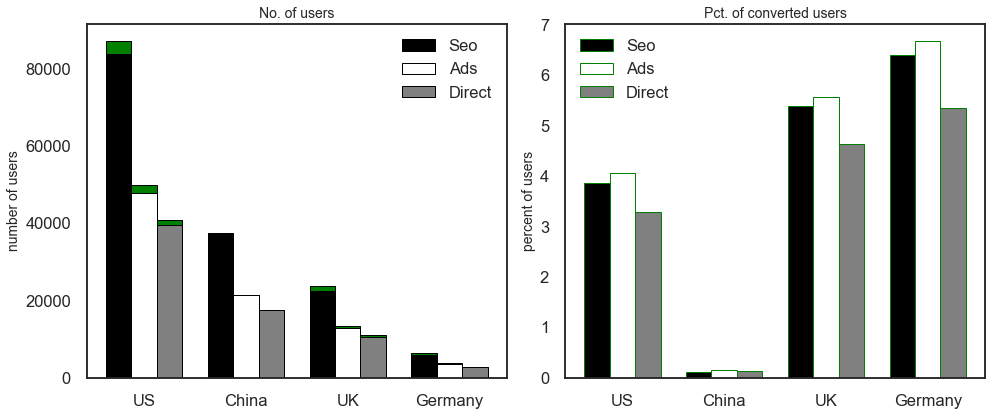

<IPython.core.display.Javascript object>

In [430]:
create_bar_plots_by_multiple_features(
    df_conv_source_country_groups_counts, country_order, 0, 0.25
)

## Source with age groups

In [442]:
df_conv_source_age_groups_counts = create_counts_converted_table_by_multiple_features(
    df_conv, "source", "age_groups"
)

<IPython.core.display.Javascript object>

In [443]:
df_conv_source_age_groups_counts.head()

source  age_groups      converted
Ads     (16.999, 23.0]  0            18685
                        1             1236
        (23.0, 28.0]    0            18442
                        1              774
        (28.0, 32.0]    0            15262
Name: age, dtype: int64

<IPython.core.display.Javascript object>

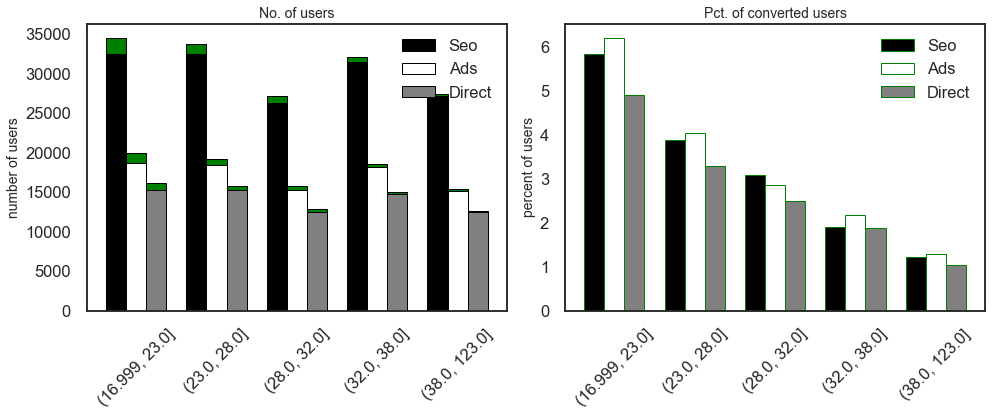

<IPython.core.display.Javascript object>

In [437]:
create_bar_plots_by_multiple_features(
    df_conv_source_age_groups_counts, age_groups_order, 45, 0.25
)

## Source with new user category

In [438]:
df_conv.head()

,country,age,new_user,source,total_pages_visited,converted,age_groups,total_page_visit_groups
0,UK,25,1,Ads,1,0,"(23.0, 28.0]","(0.999, 2.0]"
1,US,23,1,Seo,5,0,"(16.999, 23.0]","(3.0, 5.0]"
2,US,28,1,Seo,4,0,"(23.0, 28.0]","(3.0, 5.0]"
3,China,39,1,Seo,5,0,"(38.0, 123.0]","(3.0, 5.0]"
4,US,30,1,Seo,6,0,"(28.0, 32.0]","(5.0, 7.0]"


<IPython.core.display.Javascript object>

In [444]:
df_conv_source_new_user_groups_counts = create_counts_converted_table_by_multiple_features(
    df_conv, "source", "new_user"
)

<IPython.core.display.Javascript object>

In [445]:
df_conv_source_new_user_groups_counts.head()

source  new_user  converted
Ads     0         0            25706
                  1             2185
        1         0            59974
                  1              875
Direct  0         0            21291
Name: age, dtype: int64

<IPython.core.display.Javascript object>

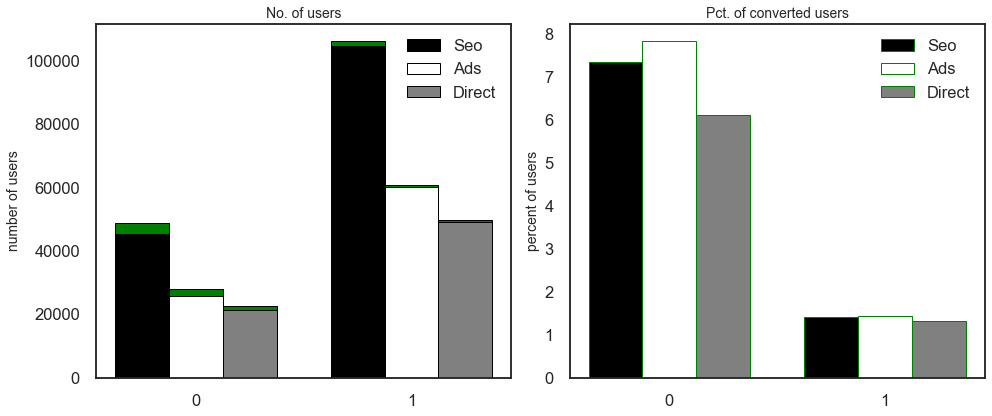

<IPython.core.display.Javascript object>

In [447]:
create_bar_plots_by_multiple_features(
    df_conv_source_new_user_groups_counts, new_user_order, 0, 0.25
)

## Source with total pages visited category

In [438]:
df_conv.head()

,country,age,new_user,source,total_pages_visited,converted,age_groups,total_page_visit_groups
0,UK,25,1,Ads,1,0,"(23.0, 28.0]","(0.999, 2.0]"
1,US,23,1,Seo,5,0,"(16.999, 23.0]","(3.0, 5.0]"
2,US,28,1,Seo,4,0,"(23.0, 28.0]","(3.0, 5.0]"
3,China,39,1,Seo,5,0,"(38.0, 123.0]","(3.0, 5.0]"
4,US,30,1,Seo,6,0,"(28.0, 32.0]","(5.0, 7.0]"


<IPython.core.display.Javascript object>

In [448]:
df_conv_source_total_page_groups_counts = create_counts_converted_table_by_multiple_features(
    df_conv, "source", "total_page_visit_groups"
)

<IPython.core.display.Javascript object>

In [449]:
df_conv_source_total_page_groups_counts.head()

source  total_page_visit_groups  converted
Ads     (0.999, 2.0]             0            23723
                                 1                3
        (2.0, 3.0]               0            12278
                                 1                7
        (3.0, 5.0]               0            21549
Name: age, dtype: int64

<IPython.core.display.Javascript object>

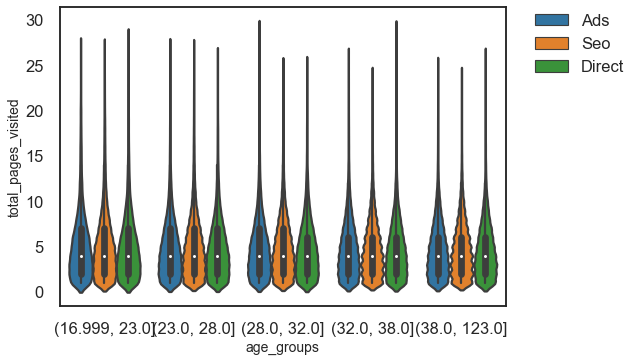

<IPython.core.display.Javascript object>

In [316]:
sns.violinplot(data=df_conv, x="age_groups", y="total_pages_visited", hue="source")
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

## Actionable insights

**Recommendations for the product team and the marketing team to improve conversion rate**

- It does not make sense to continue investing in China, but UK and Germany are under invested Germany are under invested. **Increase product presence in UK and Germany.**

- 17-23 year olds is the age group with the best chances of conversion, with increasing age inversely correlating with conversion rate. **Increase cross-platform advertising that focuses on late-teens and early 20s.**

- While there are fewer returning users than new users, they tend to have a much higher conversion rate. **Focus resources on those that may return to the site.**

- The sources are not significantly different in terms of conversion rate but most arrive to the site via search. **Invest to increase product promotion at the top of Google search queries.**

- Those that spend the most time on the site convert at a high rate, particularly after reaching 7 total page visits. **Increase site engagement.**

## Next steps

- Increase cohort segmentation. While focus was made on the customer source, binning can be made across different categories (for example, age and country).